In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir data
!unzip -qq /content/drive/My\ Drive/Projects/Crowd\ Count/Dataset/dataset.zip -d ./data

In [0]:
!mkdir data/processed

In [0]:
from os.path import join
import cv2

def process_images(read_folder, save_folder, file):
    read_path = join(read_folder, file)
    save_path = join(save_folder, file)

    img = cv2.imread(read_path, 0)
    img = cv2.resize(img, (555,555))

    cv2.imwrite(save_path, img)

    return save_path

In [5]:
import pandas as pd

data = pd.read_csv("data/labels.csv")
labels = data["count"].values
print(labels[0:10])

[35 41 41 44 41 41 35 36 27 24]


In [6]:
from os import listdir
from tqdm import tqdm

read_folder = "data/frames/"
save_folder = "data/processed/"

images = listdir("data/frames/")

dataset = []

for index, image in tqdm(enumerate(images)):
    save_path = process_images(read_folder, save_folder, image)
    dataset.append([save_path, labels[index]])

2000it [00:11, 177.21it/s]


In [7]:
print(dataset[0:10])

[['data/processed/seq_001977.jpg', 35], ['data/processed/seq_001383.jpg', 41], ['data/processed/seq_000435.jpg', 41], ['data/processed/seq_001026.jpg', 44], ['data/processed/seq_000026.jpg', 41], ['data/processed/seq_001034.jpg', 41], ['data/processed/seq_001127.jpg', 35], ['data/processed/seq_001909.jpg', 36], ['data/processed/seq_001223.jpg', 27], ['data/processed/seq_000276.jpg', 24]]


In [8]:
import pandas as pd

df = pd.DataFrame(dataset, columns=["path", "count"])

print(df.head())

                            path  count
0  data/processed/seq_001977.jpg     35
1  data/processed/seq_001383.jpg     41
2  data/processed/seq_000435.jpg     41
3  data/processed/seq_001026.jpg     44
4  data/processed/seq_000026.jpg     41


In [0]:
df.to_csv("data/processed.csv", index=False)

In [10]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.15, random_state=1969)

print(train_data.shape, test_data.shape)

(1700, 2) (300, 2)


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rotation_range=360,
    rescale=1./255,
    horizontal_flip=True,
	vertical_flip=True,
    validation_split=0.2
)

test_generator = ImageDataGenerator(rescale=1./255)

In [12]:
train_data_gen = train_generator.flow_from_dataframe(
    train_data, 
    x_col="path", 
    y_col="count",
    target_size=(555,555),
    color_mode="grayscale",
    class_mode="other",
    batch_size=32
)

test_data_gen = test_generator.flow_from_dataframe(
    test_data, 
    x_col="path", 
    y_col="count",
    target_size=(555,555),
    color_mode="grayscale",
    class_mode="other",
    batch_size=32
)

Found 1700 validated image filenames.
Found 300 validated image filenames.


In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding="same", activation="relu", input_shape=(555,555,1)))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer="adam")

In [40]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 555, 555, 32)      832       
_________________________________________________________________
flatten_4 (Flatten)          (None, 9856800)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9856801   
Total params: 9,857,633
Trainable params: 9,857,633
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
history = model.fit(train_data_gen, epochs=2, steps_per_epoch=1700 // 32)

Epoch 1/2
53/53 [==============================] - 37s 701ms/step - loss: 17158.6035
Epoch 2/2
53/53 [==============================] - 37s 701ms/step - loss: 159.1470


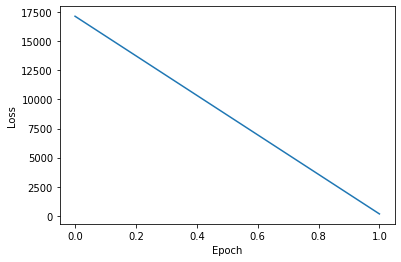

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()